# Homework 4
Sarah Henry

Import statments

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

## 1. 
Adapt the code from class that reads GHCN Daily Data from Amazon Web Services and write a function that will download the station you want (called with a GHCN station ID), and calculate (1) the all time record high and low and (2) the normal (mean) high and low temperature FOR EACH CALENDAR DAY for the 1991-2020 period for the desired station.  The function should return a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp'] FOR EACH DAY.  Write a code that can call this function and successfully demonstrate that it works.

In [8]:
def get_GHCN_data(station_ID, year=('1991','2020')):
    """This function takes a GHCN station ID and 
    calculates the record high and low temperatures 
    and the average high and low temperatures 
    from 1991 to 2020.

    Args:
        station_ID (string): the GHCN station ID for desired station
        year (tuple or string): a tuple of the range of years or 
            string of the desired year

    Returns:
        pandas.DataFrame: 'record_min_temp', 'average_min_temp', 
            'average_max_temp', 'record_max_temp' for each calendar day
    """    
    # download the station data
    df = pd.read_parquet(
        f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_ID}/",
        storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
    )

    # make date the index
    df['DATE'] = pd.to_datetime(df['DATE'].apply(lambda x: datetime.strptime(x, '%Y%m%d')))
    df = df.set_index('DATE').sort_index()  # we need to sort by time because the files are sorted arbitrarily
    
    # station data for the desired time period
    if isinstance(year, tuple):
        start_year, end_year = year
        df_period = df.loc[start_year:end_year]
    else:
        df_period = df.loc[year]

    # extract daily TMIN and TMAX (convert from tenths of °C to °C)
    tmin = df_period[df_period["ELEMENT"] == "TMIN"].copy()
    tmax = df_period[df_period["ELEMENT"] == "TMAX"].copy()
    tmin["DATA_VALUE"] = tmin["DATA_VALUE"] / 10.0
    tmax["DATA_VALUE"] = tmax["DATA_VALUE"] / 10.0

    # create a month-day column to group by calendar day
    tmin["month_day"] = tmin.index.strftime("%m-%d")
    tmax["month_day"] = tmax.index.strftime("%m-%d")

    # compute record and average values for each calendar day
    record_min_temp = tmin.groupby("month_day")["DATA_VALUE"].min()
    average_min_temp = tmin.groupby("month_day")["DATA_VALUE"].mean()
    average_max_temp = tmax.groupby("month_day")["DATA_VALUE"].mean()
    record_max_temp = tmax.groupby("month_day")["DATA_VALUE"].max()

    # combine all into a single DataFrame
    return_df = pd.DataFrame({
        'record_min_temp': record_min_temp,
        'average_min_temp': average_min_temp,
        'average_max_temp': average_max_temp,
        'record_max_temp': record_max_temp
    })

    return return_df

In [9]:
stn_ids = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt', header=None, infer_nrows=1000)
stn_ids.columns = ['ID','LAT','LON','ELEV','UKN','NAME','GSN','WBAN']

test_station_ID = stn_ids["ID"].iloc[50]
test_data = get_GHCN_data(test_station_ID)
test_data

,record_min_temp,average_min_temp,average_max_temp,record_max_temp
month_day,,,,
01-01,1.1,6.580000,16.935294,21.9
01-02,1.0,6.576471,16.133333,20.8
01-03,1.0,6.876190,16.073684,20.2
01-04,2.5,6.044444,15.894737,21.3
01-05,1.2,5.757895,16.115789,23.0
...,...,...,...,...
12-27,0.6,6.131818,15.813636,20.4
12-28,1.4,7.917391,16.415000,20.3
12-29,1.6,6.353333,16.257143,18.6


## 2. 

Develop a plot (using matplotlib) that displays for the city of choice a plot showing the record, average, and actual high and low temperatures for that year and city for each day over the calendar year.  Note: You do not need to make the chart interactive, you can just plot the data from a your city and for the year of your choice.
You are permitted to use the "weather" example from the bokeh gallery as inspiration.  An example for what the plot could look like is here: Weather, and the GitHub repository for the dashboard is here. Note that you do not have to use bokeh for this assignment, you can use matplotlib!


In [10]:
def plot_city_weather(station_ID, city_name, year='2015', climatology_years=('1991', '2020')):
    """
    Plots record, average, and actual high/low temperatures 
    for a given station and year using GHCN data.

    Args:
        station_ID (str): GHCN station ID (e.g., 'USW00013904' for Austin, TX)
        city_name (str): City name for plot title
        year (str): Target year for actual data
        climatology_years (tuple): Start and end years for climatology
    """
    
    # get climatology data for the desired time period
    clim_df = get_GHCN_data(station_ID, climatology_years)

    # get the actual data for the desired year
    # note that for only one year, the mean will return the value itself for each day
    year_df = get_GHCN_data(station_ID, year)

    # prepare climatology indexed by day of year
    clim_df = clim_df.copy()
    clim_df["dayofyear"] = [
        datetime.strptime(f"2000-{d}", "%Y-%m-%d").timetuple().tm_yday for d in clim_df.index
    ]
    clim_df = clim_df.set_index("dayofyear")

    # define variables for plotting
    days = clim_df.index
    record_min = clim_df["record_min_temp"]
    record_max = clim_df["record_max_temp"]
    avg_min = clim_df["average_min_temp"]
    avg_max = clim_df["average_max_temp"]
    actual_min = year_df["average_min_temp"]
    actual_max = year_df["average_max_temp"]

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.fill_between(days, record_min, record_max, color='thistle', alpha=0.4, label='Record Range')
    ax.fill_between(days, avg_min, avg_max, color='mediumpurple', alpha=0.6, label='Average Range')
    ax.vlines(actual_min.index, actual_min.values, actual_max.values, color='darkslateblue', linewidth=0.5, label='Actual')
    
    ax.set_xlim(1, 366)
    # ax.set_ylim(-10, 45)
    ax.set_xticks([15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345])  # midpoints of each month
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_title(f"Weather Data for {city_name}, {year}", fontsize=14, weight='bold')
    ax.set_xlabel("Day of Year")
    ax.set_title(f"Weather Data for {city_name}, {year}", fontsize=14, weight='bold')
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [12]:
# line run in M3N1 to find ID for champaign:
# merged_stns[merged_stns['NAME'].str.contains('CHAMPAIGN', regex=False)]

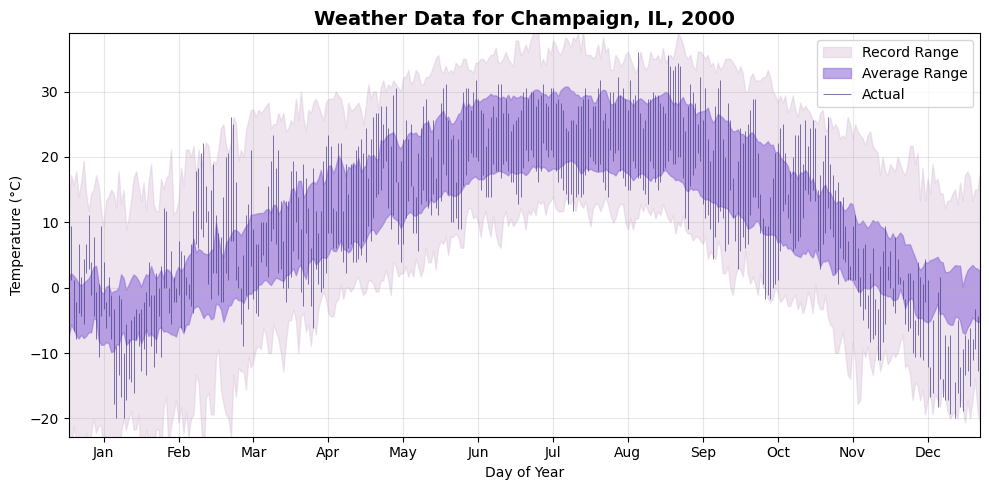

In [ ]:
plot_city_weather('USC00118740', 'Champaign, IL', year='')